# 0. 

기본 모듈

In [ ]:
!pip install holiday
!pip install prophet
!pip install pystan~=2.14
!pip install fbprophet 
!pip install statsmodels==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 120 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638206 sha256=5417ab8d5fb86ea7de08075c8500b11117c4e9f87ac8cf0e3997362ab940accc
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found 

In [ ]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
# Prophet Library
from fbprophet import Prophet

# Prophet 시각화 도구
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import datetime
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 불러오기

In [ ]:
#matplotlib font 설정
import matplotlib .pyplot as plt
plt.rc('font', family='NanumGothic')

In [ ]:
grape = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/캠벨얼리_전처리후.csv') 
shinemuscat = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/샤인머스켓_전처리후.csv') 

In [ ]:
display(grape.head(2))
display(shinemuscat.head(2))

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),캠벨얼리_거래량의_1주전_평균,캠벨얼리_가격의_1주전_평균,캠벨얼리_거래량의_2주전_평균,캠벨얼리_가격의_2주전_평균,계절
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2016-01-02,토요일,880.0,2014.0,0.0,0.0,0.0,0.0,0


,date,요일,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),샤인마스캇_거래량의_1주전_평균,샤인마스캇_가격의_1주전_평균,샤인마스캇_거래량의_2주전_평균,샤인마스캇_가격의_2주전_평균,계절
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2016-01-02,토요일,0.0,0.0,0.0,0.0,0.0,0.0,0


# 2. 캠벨얼리

In [ ]:
grape['date'] = pd.to_datetime(grape['date'])
grape.set_index('date',drop=True,inplace=True)

In [ ]:
import matplotlib.font_manager as fm
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

sys_font number: 27


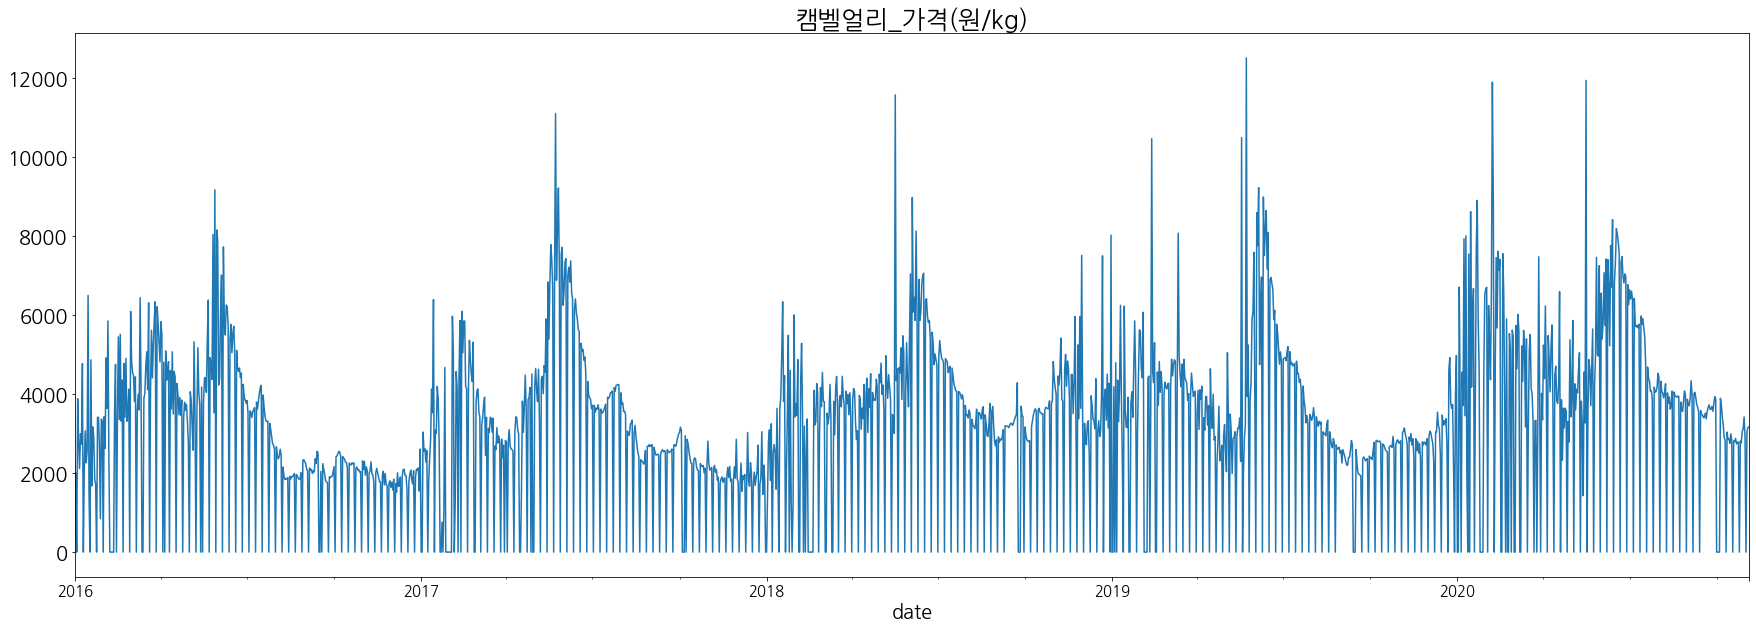

In [ ]:
plt.title('캠벨얼리_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
grape['캠벨얼리_가격(원/kg)'].plot(figsize=(30,10))

In [ ]:
grape.columns

Index(['요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '캠벨얼리_거래량의_1주전_평균',
       '캠벨얼리_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절'],
      dtype='object')

In [ ]:
# train 20190101 ~ 20200928 / test 20200929 ~ 20201104

split = 1733

main_df = grape.reset_index()

main_df = pd.DataFrame() # 빈데이터 프레임 생성 
main_df['ds'] = grape.reset_index(drop=False)['date'] # 시간 부분 넣기 
main_df['y'] = grape.reset_index(drop=False)['캠벨얼리_가격(원/kg)'] # 가격
main_train_df = main_df[:split]
main_test_df = main_df[split:]

x_col = ['캠벨얼리_거래량(kg)', '캠벨얼리_거래량의_1주전_평균',
       '캠벨얼리_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절']
X_train_prophet_df = grape.reset_index(drop=False)[x_col][:split]
X_test_prophet_df = grape.reset_index(drop=False)[x_col][split:] 

yx_train_prophet_df = pd.concat(
    [main_train_df, X_train_prophet_df], axis = 1
)
yx_test_prophet_df = pd.concat(
    [main_test_df, X_test_prophet_df], axis = 1
)
yx_train_prophet_df.head(2) #  Prophet 학습시에는 꼭 df, y, x변수 순서대로 쌓인 df를 밀어넣어야 함
yx_test_prophet_df.shape

(37, 8)

In [ ]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(yx_train_prophet_df) 

In [ ]:
future_data = prophet.make_future_dataframe(periods = 37, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1765,2020-10-31,5235.616737,3607.853089,6798.403843
1766,2020-11-01,-368.498940,-1803.557113,1177.248368
1767,2020-11-02,5005.083130,3366.733800,6571.917327
1768,2020-11-03,5169.607305,3547.584209,6741.674021
1769,2020-11-04,5084.638335,3458.640084,6604.396111


- ds = 날짜 데이터(시간데이터)
- yhat = 예측 값
- yhat_lower = 예측 데이터 최소값
- yhat_upper = 예측 데이터 최대값

Text(0.5, 1.0, '값 비교')

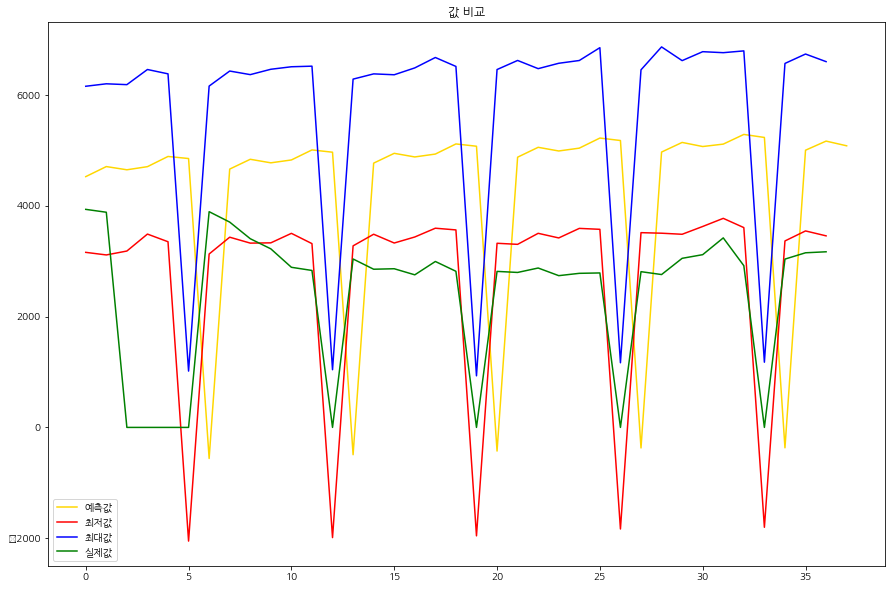

In [ ]:
plt.figure(figsize=(15, 10))

# 마지막 37일의 예측 데이터 (2020-09-29 ~ 2020-11-04)
pred_fbprophet_y = forecast_data.yhat.values[-38:]

# 실제 37일의 데이터 (2020-09-29 ~ 2020-11-04)
test_y = yx_test_prophet_df.y.values

# 마지막 37일의 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-37:]
# 마지막 37일의 예측 데이터 최대값
pred_y_upper = forecast_data.yhat_upper.values[-37:]

# 모델이 예측한 가격 그래프
plt.plot(pred_fbprophet_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")

In [ ]:
y_pred = forecast_data.yhat.values[-37:]

In [ ]:
test_y.shape

(37,)

In [ ]:
rmse = round(math.sqrt(mean_squared_error(test_y, y_pred)),2)
r2 = r2_score(test_y, y_pred)

print(rmse)
print(r2)

2222.3
-1.8868161192851987


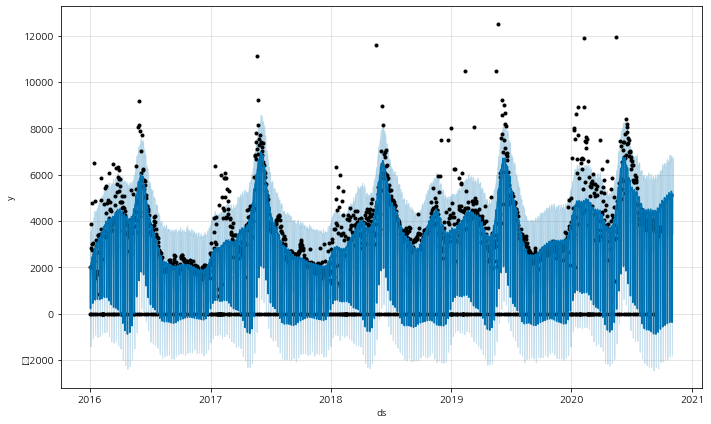

In [ ]:
fig1 = prophet.plot(forecast_data)
# 까만점은 실제데이터, 파란선은 예측값, 하늘색은 신뢰도 85퍼센트의 예측 구간

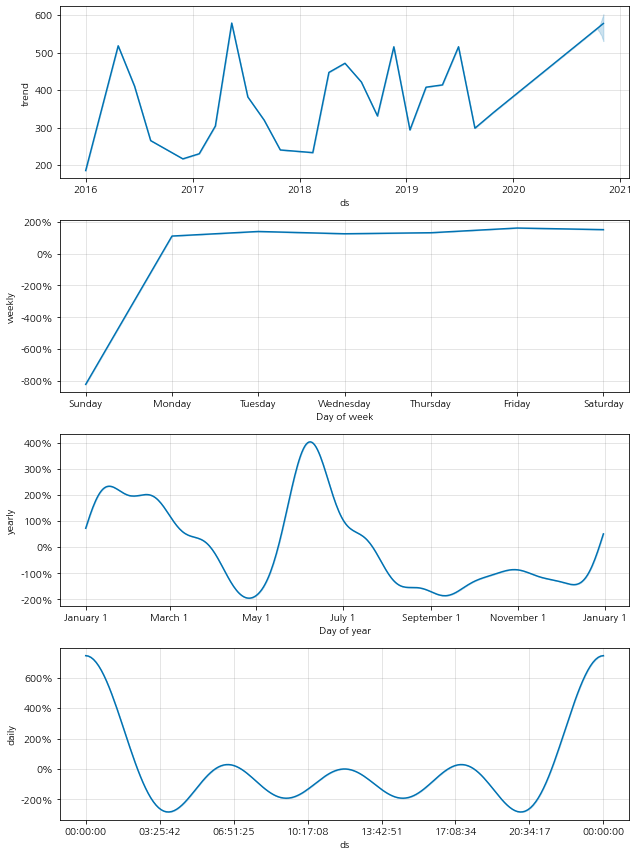

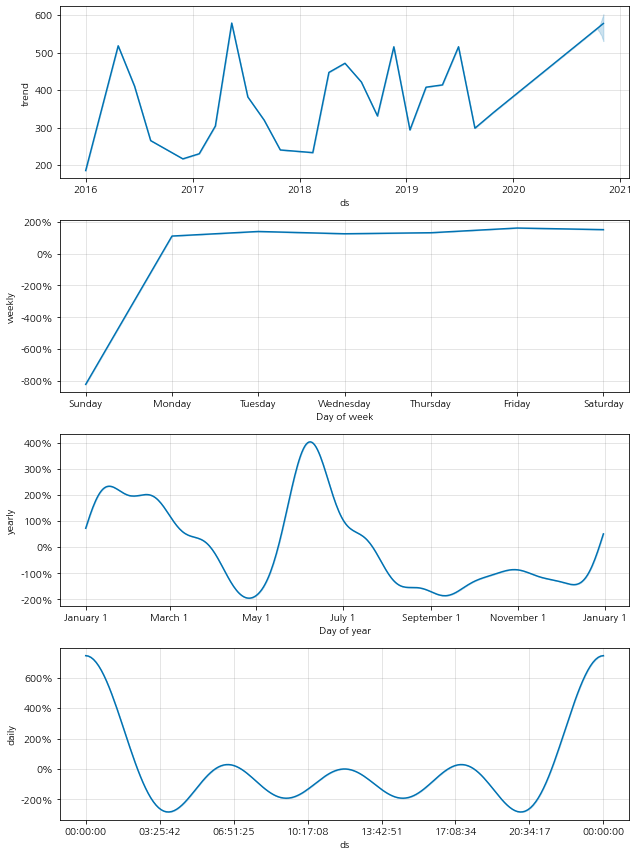

In [ ]:
fig = prophet.plot_components(forecast_data)
fig

In [ ]:
result = pd.DataFrame()
result = forecast_data[['yhat_lower','yhat_upper','yhat']]
temp_df = pd.DataFrame()
temp_df = grape[1733:]
result['real'] = temp_df['캠벨얼리_가격(원/kg)'].reset_index(drop=True)
temp_df.reset_index(inplace=True)
result['time'] = temp_df['date']
result.dropna(inplace=True)
result.set_index('time',drop=True,inplace=True)
result

,yhat_lower,yhat_upper,yhat,real
time,,,,
2020-09-29,467.715480,3513.833810,1981.214573,3937.0
2020-09-30,590.186080,3583.373802,2026.569591,3885.0
2020-10-01,-1408.732418,1738.776058,223.365405,0.0
2020-10-02,603.873378,3563.740341,2077.352861,0.0
2020-10-03,614.586841,3672.142844,2197.703125,0.0
2020-10-04,649.331221,3726.481130,2232.855553,0.0
2020-10-05,759.763111,3897.835800,2308.642130,3895.0
2020-10-06,928.823369,3910.561110,2431.334836,3707.0
2020-10-07,898.733554,3990.414114,2471.111729,3407.0


In [ ]:
# 비교하여 그래프 그려주는 함수 제작 

def vsplot(df):
  plt.plot(df.index,df['yhat'], label='forecast data', color='blue')
  plt.fill_between(df.index,df['yhat_upper'],df['yhat_lower'],color='skyblue',label='80% confidence interval')
  plt.scatter(df.index,df['real'], label='Real data ', color='black')
  plt.legend()
  plt.xlabel('date')
  plt.ylabel('캠벨얼리_가격(원/kg)')
  plt.show()

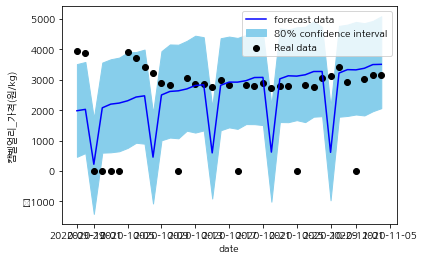

In [ ]:
vsplot(result)

# 3. 샤인머스켓

In [ ]:
shinemuscat['date'] = pd.to_datetime(shinemuscat['date'])
shinemuscat.set_index('date',drop=True,inplace=True)

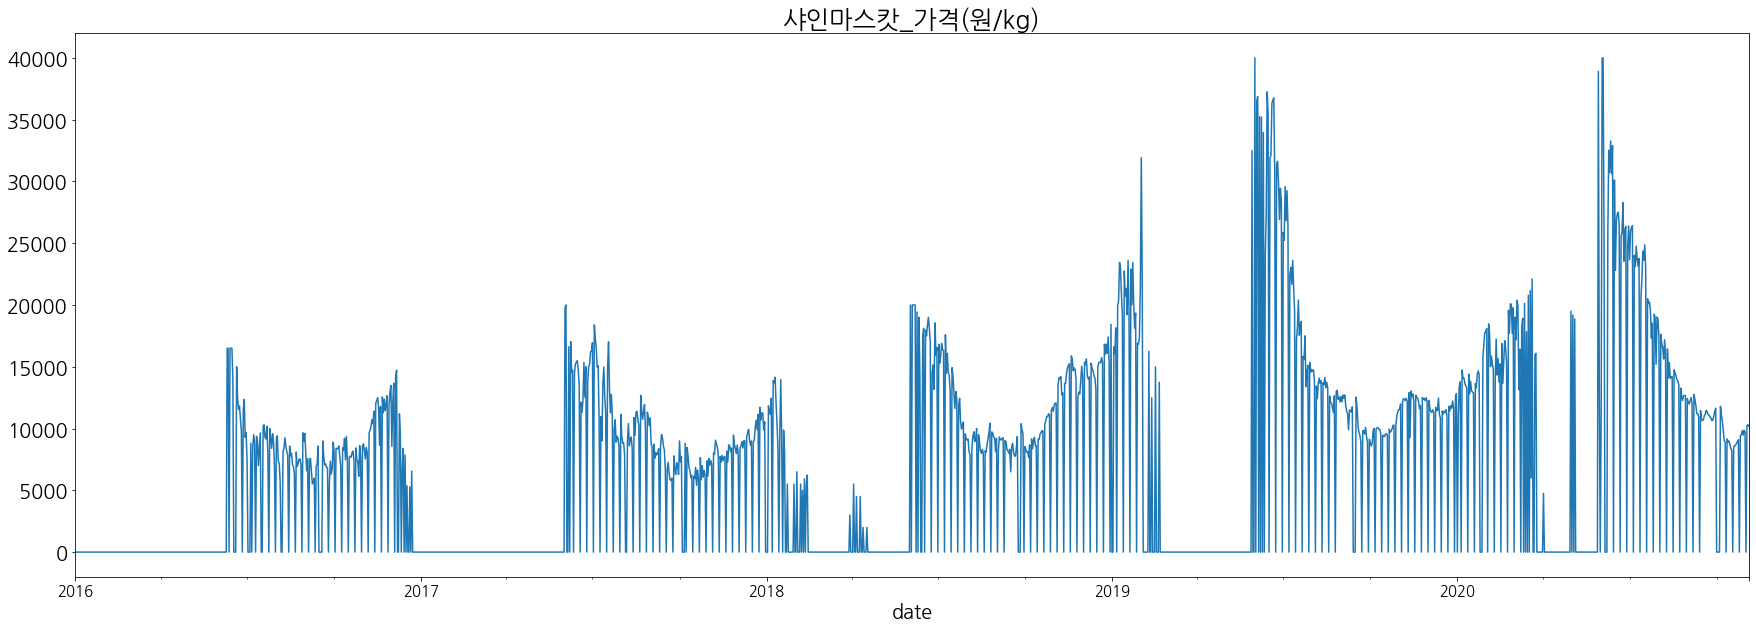

In [ ]:
plt.title('샤인마스캇_가격(원/kg)', fontsize=25)
plt.xlabel('기간', fontsize = 20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 20)
shinemuscat['샤인마스캇_가격(원/kg)'].plot(figsize=(30,10))

In [ ]:
shinemuscat.columns

Index(['요일', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '샤인마스캇_거래량의_1주전_평균',
       '샤인마스캇_가격의_1주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절'],
      dtype='object')

In [ ]:
# train 20190101 ~ 20200928 / test 20200929 ~ 20201104

split = 1733

main_df = shinemuscat.reset_index()

main_df = pd.DataFrame() # 빈데이터 프레임 생성 
main_df['ds'] = shinemuscat.reset_index(drop=False)['date'] # 시간 부분 넣기 
main_df['y'] = shinemuscat.reset_index(drop=False)['샤인마스캇_가격(원/kg)'] # 가격

main_train_df = main_df[:split]
main_test_df = main_df[split:]

x_col = ['샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '샤인마스캇_거래량의_1주전_평균',
       '샤인마스캇_가격의_1주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절']
X_train_prophet_df = shinemuscat.reset_index(drop=False)[x_col][:split]
X_test_prophet_df = shinemuscat.reset_index(drop=False)[x_col][split:] 

yx_train_prophet_df = pd.concat(
    [main_train_df, X_train_prophet_df], axis = 1
)
yx_test_prophet_df = pd.concat(
    [main_test_df, X_test_prophet_df], axis = 1
)
yx_train_prophet_df.head(2) #  Prophet 학습시에는 꼭 df, y, x변수 순서대로 쌓인 df를 밀어넣어야 함
yx_test_prophet_df.shape

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(yx_train_prophet_df)

In [ ]:
future_data = prophet.make_future_dataframe(periods = 37, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1765,2020-10-31,17478.428152,11863.281776,22685.380684
1766,2020-11-01,954.227600,-4099.849294,5267.898878
1767,2020-11-02,18282.622774,12109.057956,23939.844596
1768,2020-11-03,17847.160799,12083.377256,23347.810120
1769,2020-11-04,17843.337684,11852.494030,23597.410423


- ds = 날짜 데이터(시간데이터)
- yhat = 예측 값
- yhat_lower = 예측 데이터 최소값
- yhat_upper = 예측 데이터 최대값

Text(0.5, 1.0, '값 비교')

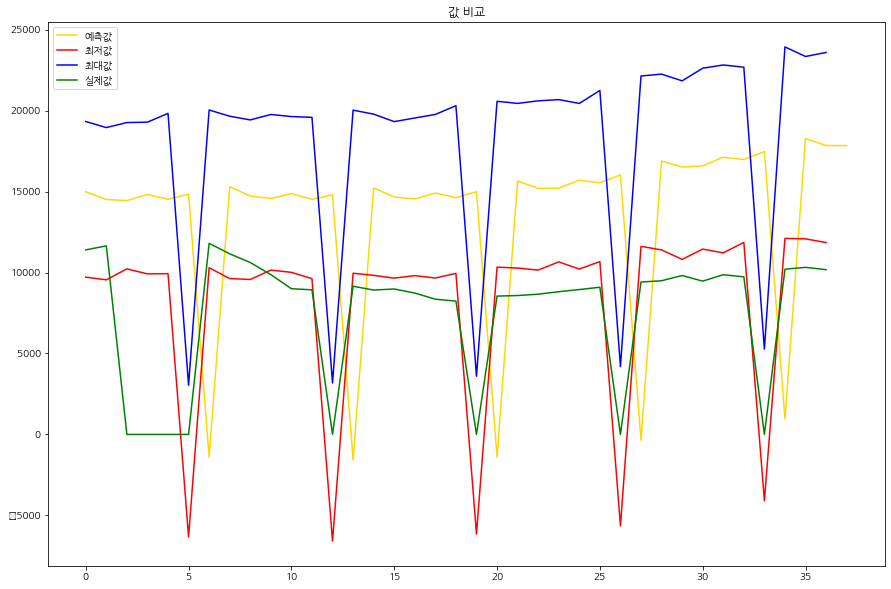

In [ ]:
plt.figure(figsize=(15, 10))

# 마지막 37일의 예측 데이터 (2020-09-29 ~ 2020-11-04)
pred_fbprophet_y = forecast_data.yhat.values[-38:]

# 실제 37일의 데이터 (2020-09-29 ~ 2020-11-04)
test_y = yx_test_prophet_df.y.values

# 마지막 37일의 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-37:]
# 마지막 37일의 예측 데이터 최대값
pred_y_upper = forecast_data.yhat_upper.values[-37:]

# 모델이 예측한 가격 그래프
plt.plot(pred_fbprophet_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")

In [ ]:
y_pred = forecast_data.yhat.values[-37:]

In [ ]:
y_pred

In [ ]:
test_y.shape

(37,)

In [ ]:
rmse = round(math.sqrt(mean_squared_error(test_y, y_pred)), 2)
r2 = r2_score(test_y, y_pred)

print(rmse)
print(r2)

6990.46
-1.9951178775546459


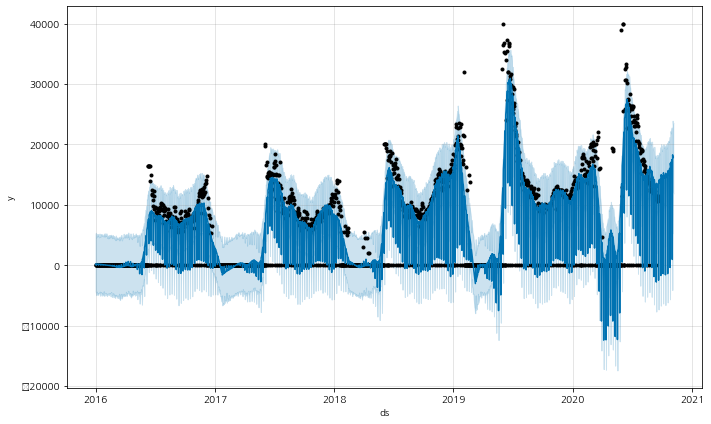

In [ ]:
fig1 = prophet.plot(forecast_data)
# 까만점은 실제데이터, 파란선은 예측값, 하늘색은 신뢰도 85퍼센트의 예측 구간

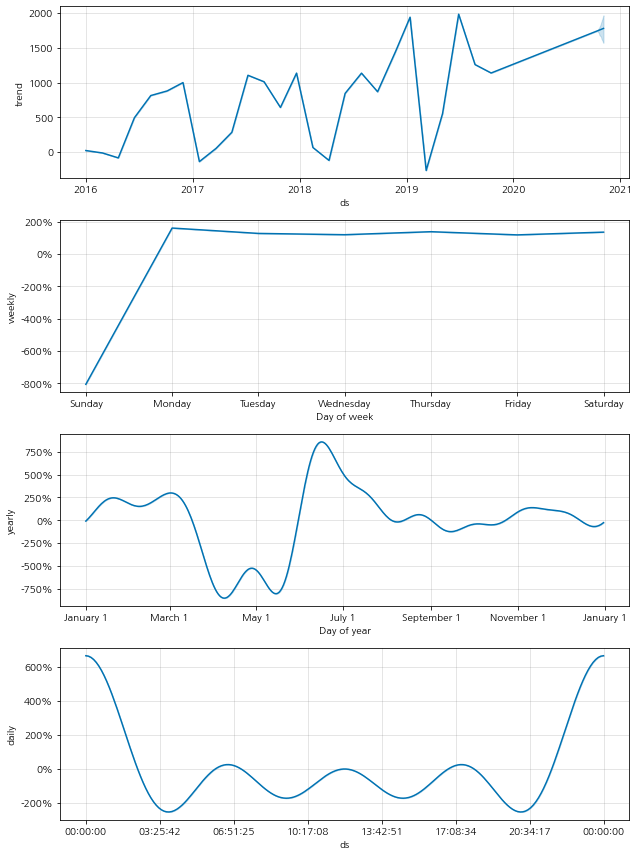

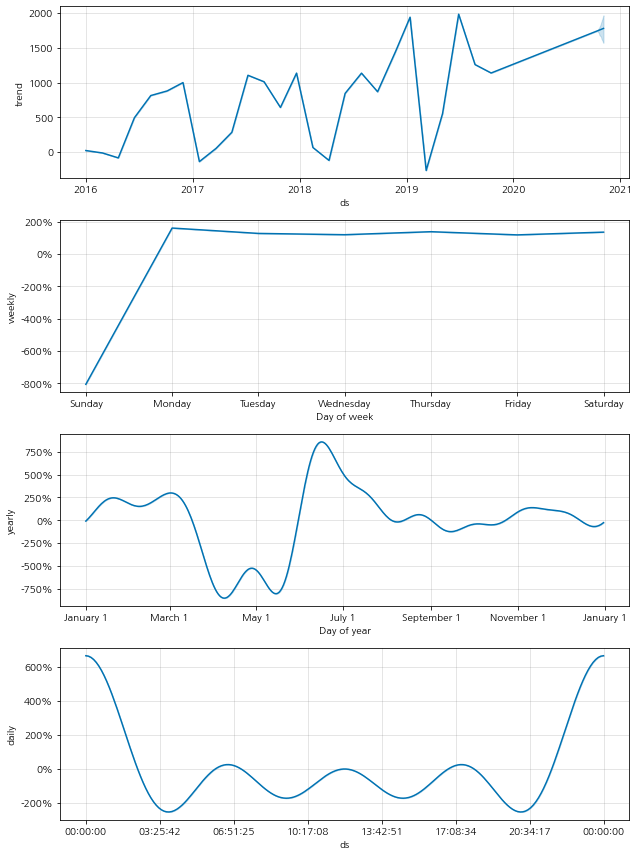

In [ ]:
fig = prophet.plot_components(forecast_data)
fig

In [ ]:
result = pd.DataFrame()
result = forecast_data[['yhat_lower','yhat_upper','yhat']]
temp_df = pd.DataFrame()
temp_df = shinemuscat[1733:]
result['real'] = temp_df['샤인마스캇_가격(원/kg)'].reset_index(drop=True)
temp_df.reset_index(inplace=True)
result['time'] = temp_df['date']
result.dropna(inplace=True)
result.set_index('time',drop=True,inplace=True)
result

,yhat_lower,yhat_upper,yhat,real
time,,,,
2020-09-29,-4293.804807,5142.064698,182.160935,11400.0
2020-09-30,-4537.992213,5382.683746,183.468671,11649.0
2020-10-01,-4956.656081,4599.569801,-6.276707,0.0
2020-10-02,-4687.980025,4781.304322,184.064170,0.0
2020-10-03,-4367.796527,5191.551053,175.526558,0.0
2020-10-04,-4838.734114,4822.771039,171.875200,0.0
2020-10-05,-4874.502910,4906.335464,172.825062,11803.0
2020-10-06,-4630.686136,5172.214843,166.857481,11159.0
2020-10-07,-4895.502090,5036.160359,166.874602,10619.0


In [ ]:
# 비교하여 그래프 그려주는 함수 제작 

def vsplot(df):
  plt.plot(df.index,df['yhat'], label='forecast data', color='blue')
  plt.fill_between(df.index,df['yhat_upper'],df['yhat_lower'],color='skyblue',label='80% confidence interval')
  plt.scatter(df.index,df['real'], label='Real data ', color='black')
  plt.legend()
  plt.xlabel('date')
  plt.ylabel('샤인마스캇_가격(원/kg)')
  plt.show()

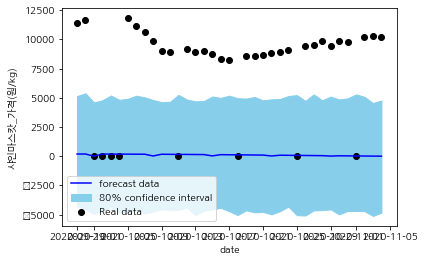

In [ ]:
vsplot(result)